# Question 6

### Question 6 [10 points]

Reproduce one of the images in Figure 3. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

/tmp/ipykernel_767/187724789.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [4]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [5]:
# celsius conversion
ds_cels = ds
ds_cels['sst_celsius'] = ds.analysed_sst - 273.15
ds_cels.coords['day_of_year'] = ds_cels.time.dt.dayofyear

# filter by year, Newport location
ds14 = ds_cels.sel(time='2014').sel(lat=45, lon=-124.061, method='nearest')
ds15 = ds_cels.sel(time='2015').sel(lat=45, lon=-124.061, method='nearest')
ds16 = ds_cels.sel(time='2016').sel(lat=45, lon=-124.061, method='nearest')

# rolling mean over 2002-2013
beforetime = ds_cels.sel(time=slice('2002','2013')).sel(lat=45, lon=-124.061, method='nearest')
rollings = beforetime.sst_celsius.rolling(time=30, center=True).mean()
rollings_grouped = rollings.groupby('day_of_year').mean()
rollings_sds = rollings.groupby('day_of_year').std()

rollings_sds['sd_lower_bound'] = rollings_grouped - rollings_sds
rollings_sds['sd_upper_bound'] = rollings_grouped + rollings_sds

# maxes and mins from 2002-2013
maxes = beforetime.sst_celsius.groupby('day_of_year').max()
mins = beforetime.sst_celsius.groupby('day_of_year').min()
extremum = beforetime.sst_celsius.groupby('day_of_year').mean()
extremum['maxes'] = maxes
extremum['mins'] = mins

# smooth the extremum
extremum['maxes'] = extremum.maxes.rolling(day_of_year=30, center=True).mean()
extremum['mins'] = extremum.mins.rolling(day_of_year=30, center=True).mean()

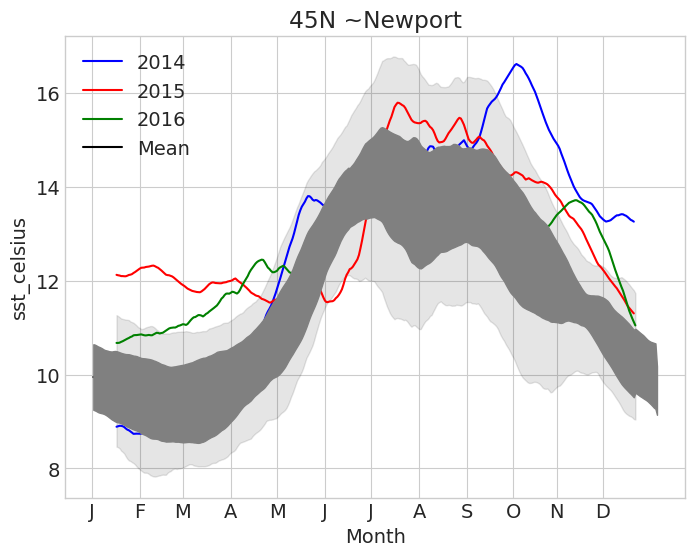

In [6]:
# plot 2014, 2015, 2016
ds14.sst_celsius.rolling(time=30, center=True).mean().plot(x='day_of_year', color='blue', label='2014')
ds15.sst_celsius.rolling(time=30, center=True).mean().plot(x='day_of_year', color='red', label='2015')
ds16.sst_celsius.rolling(time=30, center=True).mean().plot(x='day_of_year', color='green', label='2016')

# plot rolling means for 2002-2013
rollings_grouped.plot(x='day_of_year', color='black', label='Mean')

# create shaded area for maximum/minimum, opaque area for +- 1 SD 
plt.fill_between(rollings_sds.day_of_year, rollings_sds.sd_lower_bound, rollings_sds.sd_upper_bound, zorder=3, color='gray')
plt.fill_between(extremum.day_of_year, extremum.mins, extremum.maxes, alpha=0.1, color='black')

# titling and labeling
plt.title('45N ~Newport')
plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 301, 331], 
           ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])  
plt.xlabel('Month')
plt.legend()

plt.savefig('outputs/q06.png')